# Telco Customer Churn Analysis

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import operator

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import shap
from lazypredict.Supervised import LazyClassifier
from plotly.offline import init_notebook_mode, iplot
from sklearn import metrics
from sklearn.metrics import (classification_report, f1_score,
                             precision_recall_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     train_test_split)
from xgboost import XGBClassifier

shap.initjs()
init_notebook_mode(connected=True)

## Read Data

In [2]:
telco_data = pd.read_csv('telco_data.csv')
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## EDA

In [3]:
telco_data.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.00,7043,7043,7043.00,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.00,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.16,NaN,NaN,32.37,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN,24.56,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.09,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.25,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN,9.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN,29.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.35,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN,55.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.85,NaN,NaN


We can see that there is no missing data in the DataFrame that we can see outright. 

Categorical Variables:

- customerID: Unique identifier for each Customer. 
- gender: Whether the customer is a male or a female.  
- Partner: Whether the customer has a partner or not (Yes, No). 
- Dependents: Whether the customer has dependents or not (Yes, No). 
- PhoneService: Whether the customer has a phone service or not (Yes, No). 
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service).
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No). 
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service).
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service). 
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service).
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service).
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service).
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service).
- Contract: The contract term of the customer (Month-to-month, One year, Two year).
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No).
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
- TotalCharges: The total amount charged to the customer. 
- Churn: Whether the customer churned or not (Yes or No). 

Numerical Variables:

- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0). 
- tenure: Number of months the customer has stayed with the company. 
- MonthlyCharges: The amount charged to the customer monthly. 


All of the Categorical Features can be changed Numerical Features using One Hot Encoding or Label Encoding. One thing to note is that Total Charges is also a categorical feature here and may have multiple blank values.

Let's start with the EDA for now and see any interesting patterns we can see in the data. 

In [4]:
temp = telco_data.groupby(['gender', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='gender', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'gender': 'Gender'
            }
            , title='Effect of Gender on Churn')

iplot(fig)

The distribution is more or less the same. Gender has no significant effect. 

In [5]:
temp = telco_data.groupby(['Partner', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='Partner', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'Partner': 'Partner'
            }
            , title='Effect of Partner on Churn')
iplot(fig)

Having a Partner does have an effect on Churn.

In [6]:
temp = telco_data.groupby(['Dependents', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='Dependents', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'Dependents': 'Dependents'
            }
            , title='Effect of Dependents on Churn')
iplot(fig)

Having Dependents does affect Churn. This is really interesting - one hypothesis can be that people with no dependents are more prone to moving and those with dependents believe more in settling. 

In [7]:
temp = telco_data.groupby(['PhoneService', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='PhoneService', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'PhoneService': 'Phone Service'
            }
            , title='Effect of Phone Service on Churn')
iplot(fig)

The distribution is more or less the same. PhoneService has no significant effect. 

In [8]:
temp = telco_data.groupby(['MultipleLines', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='MultipleLines', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'MultipleLines': 'Multiple Lines'
            }
            , title='Effect of Multiple Lines on Churn')
iplot(fig)

Multiple Lines does not have a significant effect. 

In [9]:
temp = telco_data.groupby(['InternetService', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='InternetService', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'InternetService': 'Internet Service'
            }
            , title='Effect of Internet Service on Churn')
iplot(fig)

Fiber optic internet service results in much more churn than DSL. 

In [10]:
temp = telco_data.groupby(['OnlineSecurity', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='OnlineSecurity', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'OnlineSecurity': 'Online Security'
            }
            , title='Effect of Online Security on Churn')
iplot(fig)

Not having Online Security enabled in the Internet does lead to more Churn. 

In [11]:
temp = telco_data.groupby(['OnlineBackup', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='OnlineBackup', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'OnlineBackup': 'Online Backup'
            }
            , title='Effect of Online Backup on Churn')
iplot(fig)

Similaryly, not having Online Backup enabled in the Internet also leads to more Churn. 

In [12]:
temp = telco_data.groupby(['DeviceProtection', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='DeviceProtection', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'DeviceProtection': 'Device Protection'
            }
            , title='Effect of Device Protection on Churn')
iplot(fig)

The internet additional features distributions looks pretty similar. Most probably these will have higher correlation. 

In [13]:
temp = telco_data.groupby(['TechSupport', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='TechSupport', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'TechSupport': 'Tech Support'
            }
            , title='Effect of Tech Support on Churn')
iplot(fig)

In [14]:
temp = telco_data.groupby(['StreamingTV', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='StreamingTV', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'StreamingTV': 'Streaming TV'
            }
            , title='Effect of Streaming TV on Churn')
iplot(fig)

Streaming TV service doesn't have a significant effect of Churn. 

In [15]:
temp = telco_data.groupby(['StreamingMovies', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='StreamingMovies', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'StreamingMovies': 'Streaming Movies'
            }
            , title='Effect of Streaming Movies on Churn')
iplot(fig)

Streaming Movies service doesn't have a significant effect of Churn. 

In [16]:
temp = telco_data.groupby(['Contract', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='Contract', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'Contract': 'Contract'
            }
            , title='Effect of Contract on Churn')
iplot(fig)

People on Month-to-Month payment contract are more prone to churn, which is intuitive. We can further condense this variable to two classes - "Month-to-Month" and "Yearly".

In [17]:
temp = telco_data.groupby(['PaperlessBilling', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='PaperlessBilling', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'PaperlessBilling': 'Paperless Billing'
            }
            , title='Effect of Paperless Billing on Churn')
iplot(fig)

Customers with Paperless Billing churn more; this may be because these people are more tech savvy and are therefore, more inclined to find the best deal for themselves. 

In [18]:
temp = telco_data.groupby(['PaymentMethod', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='PaymentMethod', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'PaymentMethod': 'Payment Method'
            }
            , title='Effect of Payment Method on Churn')
iplot(fig)

Customers with Electronic Check as a payment method churn more; the above hypothesis may ring true here as well. This feature can be condensed two two parts - "Automatic" and "Not Automatic". 

In [19]:
telco_data['SeniorCitizen'] = telco_data['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')
temp = telco_data.groupby(['SeniorCitizen', 'Churn']).count()['customerID'].reset_index()
fig = px.bar(temp, x='SeniorCitizen', y='customerID', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'customerID': 'Count',
                     'SeniorCitizen': 'Senior Citizen'
            }
            , title='Effect of Senior Citizen on Churn')
iplot(fig)

Senior Citizens churn more. 

In [20]:
fig = px.histogram(telco_data, x='tenure', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'tenure': 'Tenure'
            }
            , title='Effect of Tenure on Churn')
iplot(fig)

Low tenure customers churn more whereas this percentage keeps of decreasing as the customer stays long with the company.  

In [21]:
fig = px.histogram(telco_data, x='MonthlyCharges', color='Churn'
            , labels={
                     'Churn': 'Churn',
                     'MonthlyCharges': 'Monthly Charges'
            }
            , title='Effect of Monthly Charges on Churn')
iplot(fig)

Low Monthly Charges result in less churn and vice versa; again intuitive. 

Let's do feature engineering to change all these features to numerical and make a heatmap of the data. 

In [22]:
telco_data['gender'] = telco_data['gender'].apply(lambda x: 1 if x=='Male' else 0)  ## Not effective linearly
telco_data['SeniorCitizen'] = telco_data['SeniorCitizen'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['Partner'] = telco_data['Partner'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['Dependents'] = telco_data['Dependents'].apply(lambda x: 1 if x=='Yes' else 0) 
telco_data['PhoneService'] = telco_data['PhoneService'].apply(lambda x: 1 if x=='Yes' else 0)  ## Not effective linearly
telco_data['MultipleLines'] = telco_data['MultipleLines'].apply(lambda x: 2 if x=='Yes' else 1 if x=='No' else 0)  ## Not effective linearly
telco_data['InternetService'] = telco_data['InternetService'].apply(lambda x: 2 if x=='DSL' else 1 if x=='Fiber optic' else 0)
telco_data['OnlineSecurity'] = telco_data['OnlineSecurity'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['OnlineBackup'] = telco_data['OnlineBackup'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['DeviceProtection'] = telco_data['DeviceProtection'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['TechSupport'] = telco_data['TechSupport'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['StreamingTV'] = telco_data['StreamingTV'].apply(lambda x: 2 if x=='Yes' else 1 if x=='No' else 0)  ## Not effective linearly
telco_data['StreamingMovies'] = telco_data['StreamingMovies'].apply(lambda x: 2 if x=='Yes' else 1 if x=='No' else 0)  ## Not effective linearly
telco_data['Contract'] = telco_data['Contract'].apply(lambda x: 1 if x=='Month-to-month' else 0) 
telco_data['PaymentMethod'] = telco_data['PaymentMethod'].apply(lambda x: 1 if x=='Electronic check' else 1 if x=='Mailed check' else 0)
telco_data['PaperlessBilling'] = telco_data['PaperlessBilling'].apply(lambda x: 1 if x=='Yes' else 0)
telco_data['Churn'] = telco_data['Churn'].apply(lambda x: 1 if x=='Yes' else 0)

In [23]:
import plotly.graph_objects as go


numerical_variables = ['tenure', 'MonthlyCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection'
                       , 'TechSupport', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'PaperlessBilling'
                       , 'Churn']

fig = px.imshow(telco_data[numerical_variables].corr(method='kendall'), text_auto=True, aspect='auto')
iplot(fig)


Also, contract and tenure has the most effect on churn.

# Modelling

Let's run a brute force feature selection to find the best features using the LightGBM Classifier. This is possible here as we don't have that many features to compare. 

In [24]:
variables = ['tenure', 'MonthlyCharges', 'gender', 'SeniorCitizen', 'MultipleLines', 'InternetService'
             , 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'OnlineSecurity', 'OnlineBackup'
             , 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

scores = {}

class_weight = {1: 0.8, 0: 1}
for L in range(10, len(variables) + 1):
    for subset in itertools.combinations(variables, L):
        check_set = list(subset)
        X = telco_data[check_set].copy()
        y = telco_data['Churn'].copy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

        clf = lgb.LGBMClassifier(class_weight=class_weight)
        clf.fit(X_train, y_train)

        accuracy = f1_score(clf.predict(X_test) , y_test)
        train_accuracy = f1_score(clf.predict(X), y)

        scores[str(check_set) + str(train_accuracy)] = accuracy

best_features = dict(sorted(scores.items(), key=operator.itemgetter(1),reverse=True))

We select 'tenure', 'MonthlyCharges', 'MultipleLines', 'InternetService', 'Partner', 'PaperlessBilling', 'OnlineSecurity', 'DeviceProtection', 'Contract', and 'PaymentMethod' as the final features. These features had the most impact on Churn. 

In [25]:
variables = ['tenure', 'MonthlyCharges', 'MultipleLines', 'InternetService', 'Partner', 'PaperlessBilling', 'OnlineSecurity', 'DeviceProtection', 'Contract', 'PaymentMethod']

target = ['Churn']

X = telco_data[variables]
y = telco_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

multiple_models = LazyClassifier(verbose=0, ignore_warnings=True, predictions=True)
models, predictions = multiple_models.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:05<00:00,  5.70it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.73,0.77,0.77,0.75,0.01
GaussianNB,0.77,0.76,0.76,0.78,0.01
QuadraticDiscriminantAnalysis,0.78,0.76,0.76,0.79,0.02
BernoulliNB,0.77,0.74,0.74,0.78,0.01
PassiveAggressiveClassifier,0.73,0.73,0.73,0.74,0.02
LGBMClassifier,0.81,0.73,0.73,0.81,0.34
XGBClassifier,0.81,0.72,0.72,0.80,0.16
AdaBoostClassifier,0.81,0.72,0.72,0.80,0.11
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.80,0.18


We see that the XGBoost Classifer is one of the best models to train our data on. Let's optimise the hyperparameters of the model and see if it results in any improvement.

In [ ]:
folds = 5
params = {
            'min_child_weight': [1, 5, 10]
          , 'gamma': [0.5, 1, 1.5, 2, 5]
          , 'subsample': [0.6, 0.8, 1.0]
          , 'colsample_bytree': [0.6, 0.8, 1.0]
          , 'max_depth': [3, 4, 5]
          , 'n_estimators': [100, 200, 500]
          , 'learning_rate': [0.01, 0.02, 0.05, 0.1]
         }

xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', nthread=-1)

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
grid = GridSearchCV(xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=skf.split(X_train, y_train), verbose=0)

grid.fit(X_train, y_train)

Let's find the best threshold for the model so we can prioritize recall while keeping a decent Precision. 

In [27]:
for i in np.arange(1, 0, -0.01):
    predict_y = np.where(grid.best_estimator_.predict_proba(X_test) >= i, 1, 0)[:,1]
    recall = (metrics.confusion_matrix(y_test, predict_y)[1, 1]) / (metrics.confusion_matrix(y_test, predict_y)[1, 1] + metrics.confusion_matrix(y_test, predict_y)[1, 0])
    if recall > 0.85:
        break

threshold = round (i, 2)
test_prob = np.where(grid.best_estimator_.predict_proba(X_test) >= threshold, 1, 0)[:,1]
train_prob = np.where(grid.best_estimator_.predict_proba(X_train) >= threshold, 1, 0)[:,1]

print('The threshold is: {}'.format(threshold))

The threshold is: 0.22


In [28]:
print(metrics.classification_report(y_test, test_prob))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      1327
           1       0.48      0.85      0.61       434

    accuracy                           0.74      1761
   macro avg       0.71      0.78      0.71      1761
weighted avg       0.82      0.74      0.75      1761



We are able to achieve 85% recall with around 50% precision to identify Churn. Now, recall is more important here in this problem as we don't want to miss predicting people who would Churn so that we can take immediate action and retain them. 

Yes, the precision is low, but see it this way - The total number of people we are classifying incorrectly as they will Churn are 30% of people who don't Churn. This 30% will result in some burn because of retaining efforts, but in return we will be able to try to retain 85% of the people who would have churned. 

# Precision - Recall Curves for Train and Test

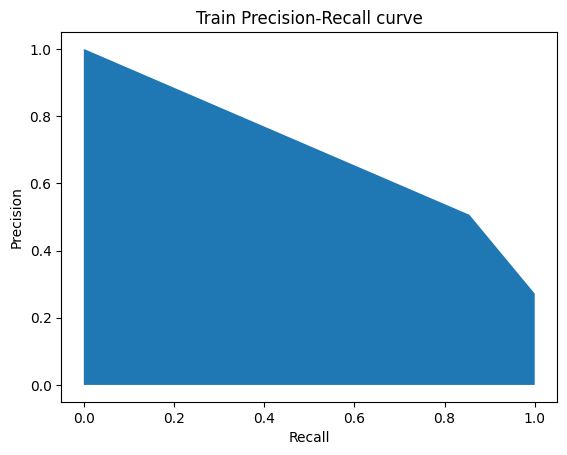

In [29]:
precision, recall, thresholds = precision_recall_curve(y_train, train_prob)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

Text(0.5, 1.0, 'Test Precision-Recall curve')

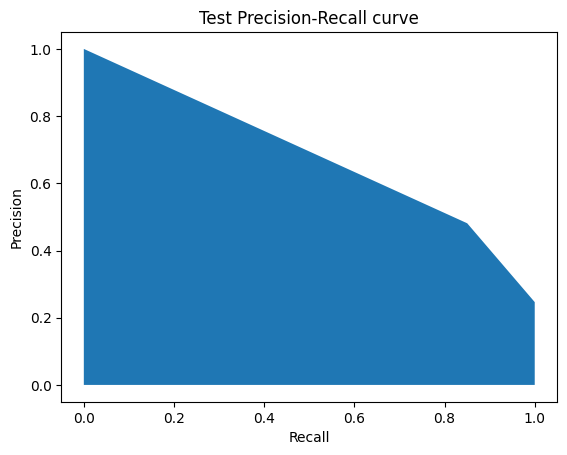

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, test_prob)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve")

# Model Explainer (SHAP)

#### Feature Importance

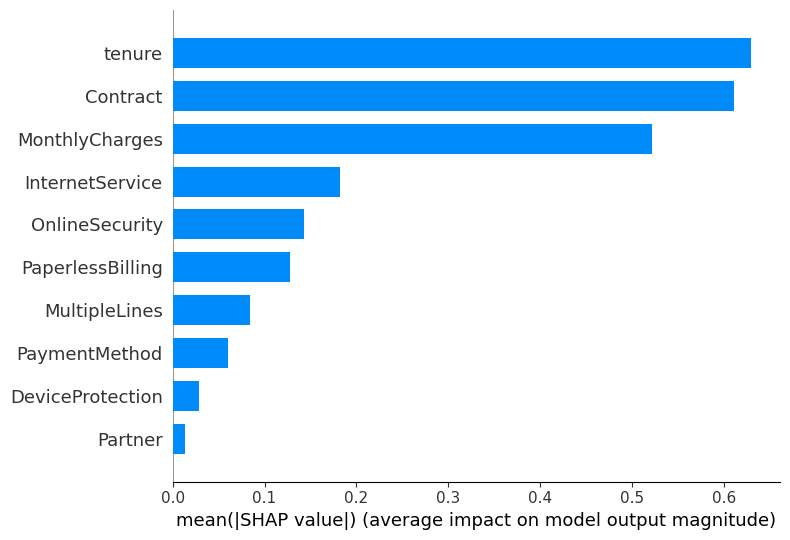

In [31]:
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

#### Indicidual Prediction Decision

A Recap on what the final metrics mean?

- Tenure: Number of months the customer has stayed with the company. 
- Contract: The contract term of the customer (0: Yearly, 1: Month-to-month).
- MonthlyCharges: The amount charged to the customer monthly. 
- InternetService: Customer’s internet service provider (0: No, 1: Fiber optic, 2: DSL). 
- OnlineSecurity: Whether the customer has online security or not - given with Internet Service (0: No, 1: Yes). 
- PaperlessBilling: Whether the customer has paperless billing or not (0: No, 1: Yes).
- MultipleLines: Whether the customer has multiple lines or not (0: No phone service, 1: No, 2: Yes).
- PaymentMethod: The customer’s payment method (0: Automatic, 1: Check).
- DeviceProtection: Whether the customer has device protection or not (0: No, 1: Yes).
- Partner: Whether the customer has a partner or not (0: No, 1: Yes). 

Threshold for Churn:  0.22


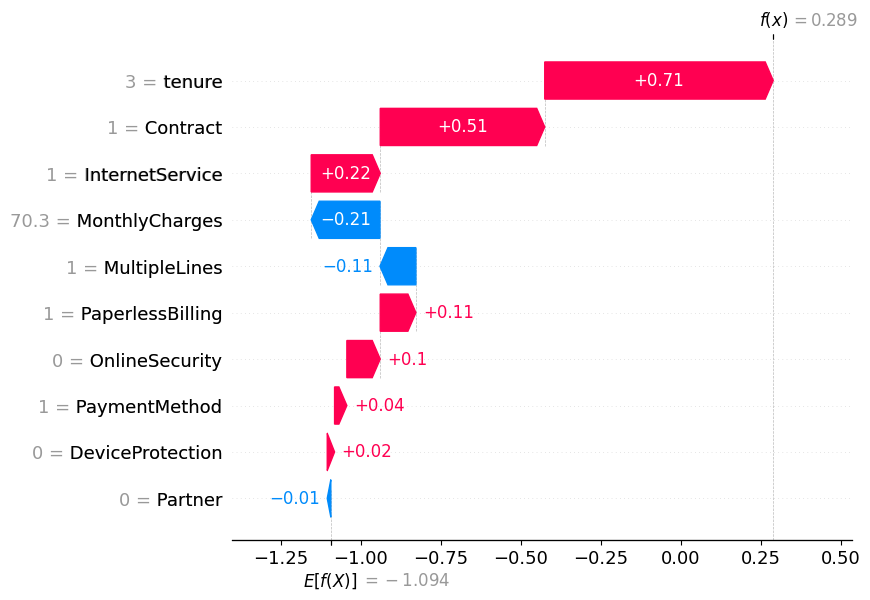

In [32]:
print('Threshold for Churn: ', threshold)
shap.plots.waterfall(explainer(X_test)[12])

The blue color denotes here the factors which will not result in Churn and the red denotes factors that lead to Churn. This is for an individual prediction and so can help us take decisions on how to nudge the customer to make sure they don't churn.

For the above case, we see that the customer is relatively new, and has a month-to-month contract - both of which are signals to make it easy for the customer to churn. Also, the Internet Service the customer has is Fiber-optic which has high Churn. Also, the Payment method chosen by the customer is through Check. The customer hasn't taken any Online Security or Device Protection as well on top of the Internet Service. 

This matches the profile of someone who would churn. Some steps we can take here are:

- Try to get the customer on an yearly contract by giving him attractive discounts and nudges. 
- Figure out why the Fibre-optic churn is so high and mitigate the chances of churn because of that. 
- Get customer to opt for an Automatic Billing, this way the customer won't be nudged each month to make the payment and lessen the chances of churn. 